# Import libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Dataset

In [52]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/DS_Project_2025/EDA_Preprocessing/StellaPreprocessing/ARMD'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
df_cohort = pd.read_csv(f'{dir}/microbiology_cultures_cohort.csv')
df_adi = pd.read_csv(f'{dir}/microbiology_cultures_adi_scores.csv')
df_demo = pd.read_csv(f'{dir}/microbiology_cultures_demographics.csv')
df_prior = pd.read_csv(f'{dir}/microbiology_culture_prior_infecting_organism.csv')
df_ward = pd.read_csv(f'{dir}/microbiology_cultures_ward_info.csv')
df_nursing = pd.read_csv(f'{dir}/microbiology_cultures_nursing_home_visits.csv')
df_antibiotic = pd.read_csv(f'{dir}/microbiology_cultures_antibiotic_class_exposure.csv')

/tmp/ipython-input-3436816210.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adi = pd.read_csv(f'{dir}/microbiology_cultures_adi_scores.csv')
/tmp/ipython-input-3436816210.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_demo = pd.read_csv(f'{dir}/microbiology_cultures_demographics.csv')


In [54]:
print("cohort information", df_cohort.shape)
print("ADI information", df_adi.shape)
print("Prior information", df_prior.shape)
print("Demographic", df_demo.shape)
print("Ward information", df_ward.shape)
print("Nusing information", df_nursing.shape)
print("Antibiotic information", df_antibiotic.shape)

cohort information (2241050, 10)
ADI information (751075, 6)
Prior information (1083739, 6)
Demographic (751075, 5)
Ward information (751075, 8)
Nusing information (7628, 5)
Antibiotic information (5402486, 8)


In [55]:
print(df_cohort.anon_id.nunique())
print(df_demo.anon_id.nunique())
print(df_adi.anon_id.nunique())
print(df_ward.anon_id.nunique())
print(df_prior.anon_id.nunique())
print(df_nursing.anon_id.nunique())
print(df_antibiotic.anon_id.nunique())

283715
283715
283715
283715
45499
3643
153555


In [56]:
# only get the first of the instance in each dataframes
# There are multiple tests done on each anonymous patient id
df_antibiotic_unique = df_antibiotic.groupby("anon_id").first().reset_index()
df_adi_unique = df_adi.groupby("anon_id").first().reset_index()
df_antibiotic_unique = df_antibiotic.groupby("anon_id").first().reset_index()
df_demo_unique = df_demo.groupby("anon_id").first().reset_index()
df_ward_unique = df_ward.groupby("anon_id").first().reset_index()
df_nursing_unique = df_nursing.groupby("anon_id").first().reset_index()

In [57]:
# first order the cohort tested time from earliest to latest
# then group by the anon_id with the same tested time and only keep the first tested time rows
# then merge back to only keep the rows matching the earliest timestamp for each anon id
df_cohort_time_ordered = df_cohort.sort_values(by=["anon_id", "order_time_jittered_utc"])
df_earliest = df_cohort_time_ordered.groupby('anon_id')['order_time_jittered_utc'].first().reset_index()
df_cohort_unique = pd.merge(df_earliest, df_cohort_time_ordered, on=['anon_id', 'order_time_jittered_utc'], how='left')
df_cohort_only = df_cohort_time_ordered.groupby('anon_id').first().reset_index()

In [58]:
# keep only the resistant/susceptible/synergism rows
df_cohort_unique = df_cohort_unique[(df_cohort_unique.susceptibility == 'Resistant') | (df_cohort_unique.susceptibility == 'Susceptible') | (df_cohort_unique.susceptibility == 'Synergism')]
df_cohort_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563795 entries, 0 to 896073
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   anon_id                  563795 non-null  object
 1   order_time_jittered_utc  563795 non-null  object
 2   pat_enc_csn_id_coded     563795 non-null  int64 
 3   order_proc_id_coded      563795 non-null  int64 
 4   ordering_mode            563795 non-null  object
 5   culture_description      563795 non-null  object
 6   was_positive             563795 non-null  int64 
 7   organism                 563795 non-null  object
 8   antibiotic               563795 non-null  object
 9   susceptibility           563795 non-null  object
dtypes: int64(3), object(7)
memory usage: 47.3+ MB


In [59]:
# change the prior dataframe such that
# no prior organism = 0
# ecoli = 1
# any other = 2
df_prior_only = df_prior[['anon_id','order_time_jittered_utc','prior_organism']]
df_prior_only.loc[:,'prior_organism'] = np.select(
    [
        df_prior_only['prior_organism'].isna(),                   # condition 1
        df_prior_only['prior_organism'] == 'Escherichia'          # condition 2
    ],
    [
        0,                                 # value if NaN
        1                                  # value if ecoli
    ],
    default=2                              # all others
)
df_prior_only = df_prior_only.drop_duplicates()

In [60]:
# change the antibiotic class exposure dataframe such that
# no prior antibiotic = 0
# any antibioitic = 1
df_antibiotic_only = df_antibiotic_unique[['anon_id', 'medication_name']]
df_antibiotic_only.loc[:,'medication_name'] = np.select(
    [df_antibiotic_only['medication_name'].isna()],
    [0],default=1)
df_antibiotic_only = df_antibiotic_only.drop_duplicates()
df_antibiotic_only = df_antibiotic_only.rename(columns={'medication_name': 'prior_antibiotic'})
df_antibiotic_only.head()

,anon_id,prior_antibiotic
0,JC1000093,1
1,JC1000129,1
2,JC1000143,1
3,JC1000158,1
4,JC1000159,1


In [61]:
# get rid of any entries with duplicated values of both resistant and susceptible
is_duplicated = df_cohort_unique.duplicated(subset=['anon_id', 'pat_enc_csn_id_coded','order_proc_id_coded',
                                  'order_time_jittered_utc','organism','antibiotic'], keep=False)


In [62]:
df_duplicates = df_cohort_unique[is_duplicated]
df_no_duplicates = df_cohort_unique[~is_duplicated]
df_no_duplicates.shape

(561801, 10)

In [63]:
map_status = {'Susceptible': 1, 'Synergism': 1, 'Resistant': 2 }
df_no_duplicates['susceptibility_map'] = df_no_duplicates['susceptibility'].map(map_status)
pivot_df = (
    df_no_duplicates.pivot_table(index='anon_id', columns='antibiotic', values='susceptibility_map', aggfunc='max')
    .fillna(0)
    .reset_index()
    .rename_axis(None, axis=1))


/tmp/ipython-input-3304260661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['susceptibility_map'] = df_no_duplicates['susceptibility'].map(map_status)


In [64]:
pivot_df = pivot_df[['anon_id','Gentamicin', 'Trimethoprim/Sulfamethoxazole', 'Ciprofloxacin',
                    'Ampicillin', 'Cefazolin','Nitrofurantoin','Piperacillin/Tazobactam',
                     'Levofloxacin', 'Ceftriaxone']]
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44805 entries, 0 to 44804
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   anon_id                        44805 non-null  object 
 1   Gentamicin                     44805 non-null  float64
 2   Trimethoprim/Sulfamethoxazole  44805 non-null  float64
 3   Ciprofloxacin                  44805 non-null  float64
 4   Ampicillin                     44805 non-null  float64
 5   Cefazolin                      44805 non-null  float64
 6   Nitrofurantoin                 44805 non-null  float64
 7   Piperacillin/Tazobactam        44805 non-null  float64
 8   Levofloxacin                   44805 non-null  float64
 9   Ceftriaxone                    44805 non-null  float64
dtypes: float64(9), object(1)
memory usage: 3.4+ MB


In [65]:
# get rid of any null rows
df_cohort_unique = df_cohort_unique[~((df_cohort_unique.organism == 'Null') | (df_cohort_unique.antibiotic == 'Null') | (df_cohort_unique.was_positive == 0) | (df_cohort_unique.susceptibility == 'Null'))]
df_cohort_only = df_cohort_only[~((df_cohort_only.organism == 'Null') | (df_cohort_only.antibiotic == 'Null') | (df_cohort_only.was_positive == 0) | (df_cohort_only.susceptibility == 'Null'))]
df_adi_unique = df_adi_unique[~((df_adi_unique.adi_score == 'Null') | (df_adi_unique.adi_state_rank == 'Null'))]
df_demo_unique = df_demo_unique[~((df_demo_unique.age == 'Null') | (df_demo_unique.gender == 'Null'))]

In [66]:
print("cohort information", df_cohort_unique.shape)
print("cohort information", df_cohort_only.shape)
print("ADI information", df_adi_unique.shape)
print("Demographic", df_demo_unique.shape)
print("Ward inform", df_ward_unique.shape)
print("Prior inform", df_prior_only.shape)

cohort information (563795, 10)
cohort information (44292, 10)
ADI information (212159, 6)
Demographic (283627, 5)
Ward inform (283715, 8)
Prior inform (204032, 3)


# Merge the csv files

In [67]:
# keep only the resistant/susceptible/synergism rows
cols = ['anon_id',	'order_time_jittered_utc',	'organism']
df_cohort_prior = pd.merge(df_cohort_only[cols],
                           df_prior_only, on=['anon_id','order_time_jittered_utc'], how='left')
print("shape of cohort and prior is", df_cohort_prior.shape)
df_cohort_prior.head()

shape of cohort and prior is (44338, 4)


,anon_id,order_time_jittered_utc,organism,prior_organism
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN


In [68]:
merged_1 = pd.merge(df_cohort_prior, df_antibiotic_only[['anon_id', 'prior_antibiotic']], on=['anon_id'], how='left')
print("shape of merged 1 is", merged_1.shape)
merged_1.head()

shape of merged 1 is (44338, 5)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN


In [69]:
merged_2 = pd.merge(merged_1, df_demo_unique[['anon_id','age', 'gender']], on=['anon_id'], how='left')
print("shape of merged 1 is", merged_2.shape)
merged_2.head()

shape of merged 1 is (44338, 7)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic,age,gender
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0


In [70]:
merged_3 = pd.merge(merged_2, df_adi_unique[['anon_id','adi_score','adi_state_rank']], on=['anon_id'], how='left')
print("shape of merged 3 is", merged_3.shape)
merged_3.head()

shape of merged 3 is (44338, 9)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic,age,gender,adi_score,adi_state_rank
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,2,1
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,NaN,NaN
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,3,2


In [71]:
merged_4 = pd.merge(merged_3, df_nursing_unique[['anon_id','nursing_home_visit_culture']], on=['anon_id'], how='left')
print("shape of merged 4 is", merged_4.shape)
merged_4.head()

shape of merged 4 is (44338, 10)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic,age,gender,adi_score,adi_state_rank,nursing_home_visit_culture
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,2,1,NaN
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,NaN,NaN,NaN
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,3,2,NaN


In [72]:
merged_5 = pd.merge(merged_4, df_ward_unique[['anon_id','hosp_ward_IP',	'hosp_ward_OP',	'hosp_ward_ER',	'hosp_ward_ICU']],
                       on=['anon_id'], how='left')
print("shape of merged 5 is", merged_5.shape)
merged_5.head()

shape of merged 5 is (44338, 14)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic,age,gender,adi_score,adi_state_rank,nursing_home_visit_culture,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN,0,1,0,0
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN,0,1,0,0
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,2,1,NaN,0,1,0,0
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,NaN,NaN,NaN,1,0,0,0
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,3,2,NaN,0,1,0,0


In [73]:
merged_6 = pd.merge(merged_5, pivot_df, on=['anon_id'], how='left')
print("shape of merged 6 is", merged_6.shape)
merged_6.head()

shape of merged 6 is (44338, 23)


,anon_id,order_time_jittered_utc,organism,prior_organism,prior_antibiotic,age,gender,adi_score,adi_state_rank,nursing_home_visit_culture,...,hosp_ward_ICU,Gentamicin,Trimethoprim/Sulfamethoxazole,Ciprofloxacin,Ampicillin,Cefazolin,Nitrofurantoin,Piperacillin/Tazobactam,Levofloxacin,Ceftriaxone
0,JC1000010,2008-05-12 03:14:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN,...,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,JC1000013,2008-04-11 23:45:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,NaN,NaN,NaN,...,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,JC1000022,2008-03-13 03:50:00+00:00,ESCHERICHIA COLI,NaN,NaN,18-24 years,0,2,1,NaN,...,0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
3,JC1000055,2009-10-15 03:25:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,NaN,NaN,NaN,...,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,JC1000080,2013-01-28 02:41:00+00:00,ESCHERICHIA COLI,NaN,NaN,25-34 years,0,3,2,NaN,...,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [74]:
print("Number of total oganisms: ", merged_6.prior_organism.value_counts())
print("Number of patients who had prior organism: ", merged_6.prior_organism.notnull().sum())
# Need to one-hot encode:
# 1 will indicate prior organism.
# 0 will indicate no prior organism.

Number of total oganisms:  prior_organism
2    684
1    152
Name: count, dtype: int64
Number of patients who had prior organism:  836


In [75]:
merged_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44338 entries, 0 to 44337
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   anon_id                        44338 non-null  object 
 1   order_time_jittered_utc        44338 non-null  object 
 2   organism                       44338 non-null  object 
 3   prior_organism                 836 non-null    object 
 4   prior_antibiotic               25796 non-null  object 
 5   age                            44309 non-null  object 
 6   gender                         44309 non-null  object 
 7   adi_score                      32714 non-null  object 
 8   adi_state_rank                 32714 non-null  object 
 9   nursing_home_visit_culture     842 non-null    float64
 10  hosp_ward_IP                   44338 non-null  int64  
 11  hosp_ward_OP                   44338 non-null  int64  
 12  hosp_ward_ER                   44338 non-null 

In [76]:
antibiotics = ['Gentamicin', 'Trimethoprim/Sulfamethoxazole', 'Ciprofloxacin',
                'Ampicillin', 'Cefazolin','Nitrofurantoin','Piperacillin/Tazobactam',
                'Levofloxacin', 'Ceftriaxone']

merged_6 = merged_6[(merged_6[antibiotics].map(lambda x: x in [1,2])).all(axis=1)]
merged_6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13460 entries, 14 to 44325
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   anon_id                        13460 non-null  object 
 1   order_time_jittered_utc        13460 non-null  object 
 2   organism                       13460 non-null  object 
 3   prior_organism                 293 non-null    object 
 4   prior_antibiotic               8169 non-null   object 
 5   age                            13455 non-null  object 
 6   gender                         13455 non-null  object 
 7   adi_score                      9917 non-null   object 
 8   adi_state_rank                 9917 non-null   object 
 9   nursing_home_visit_culture     187 non-null    float64
 10  hosp_ward_IP                   13460 non-null  int64  
 11  hosp_ward_OP                   13460 non-null  int64  
 12  hosp_ward_ER                   13460 non-null  int

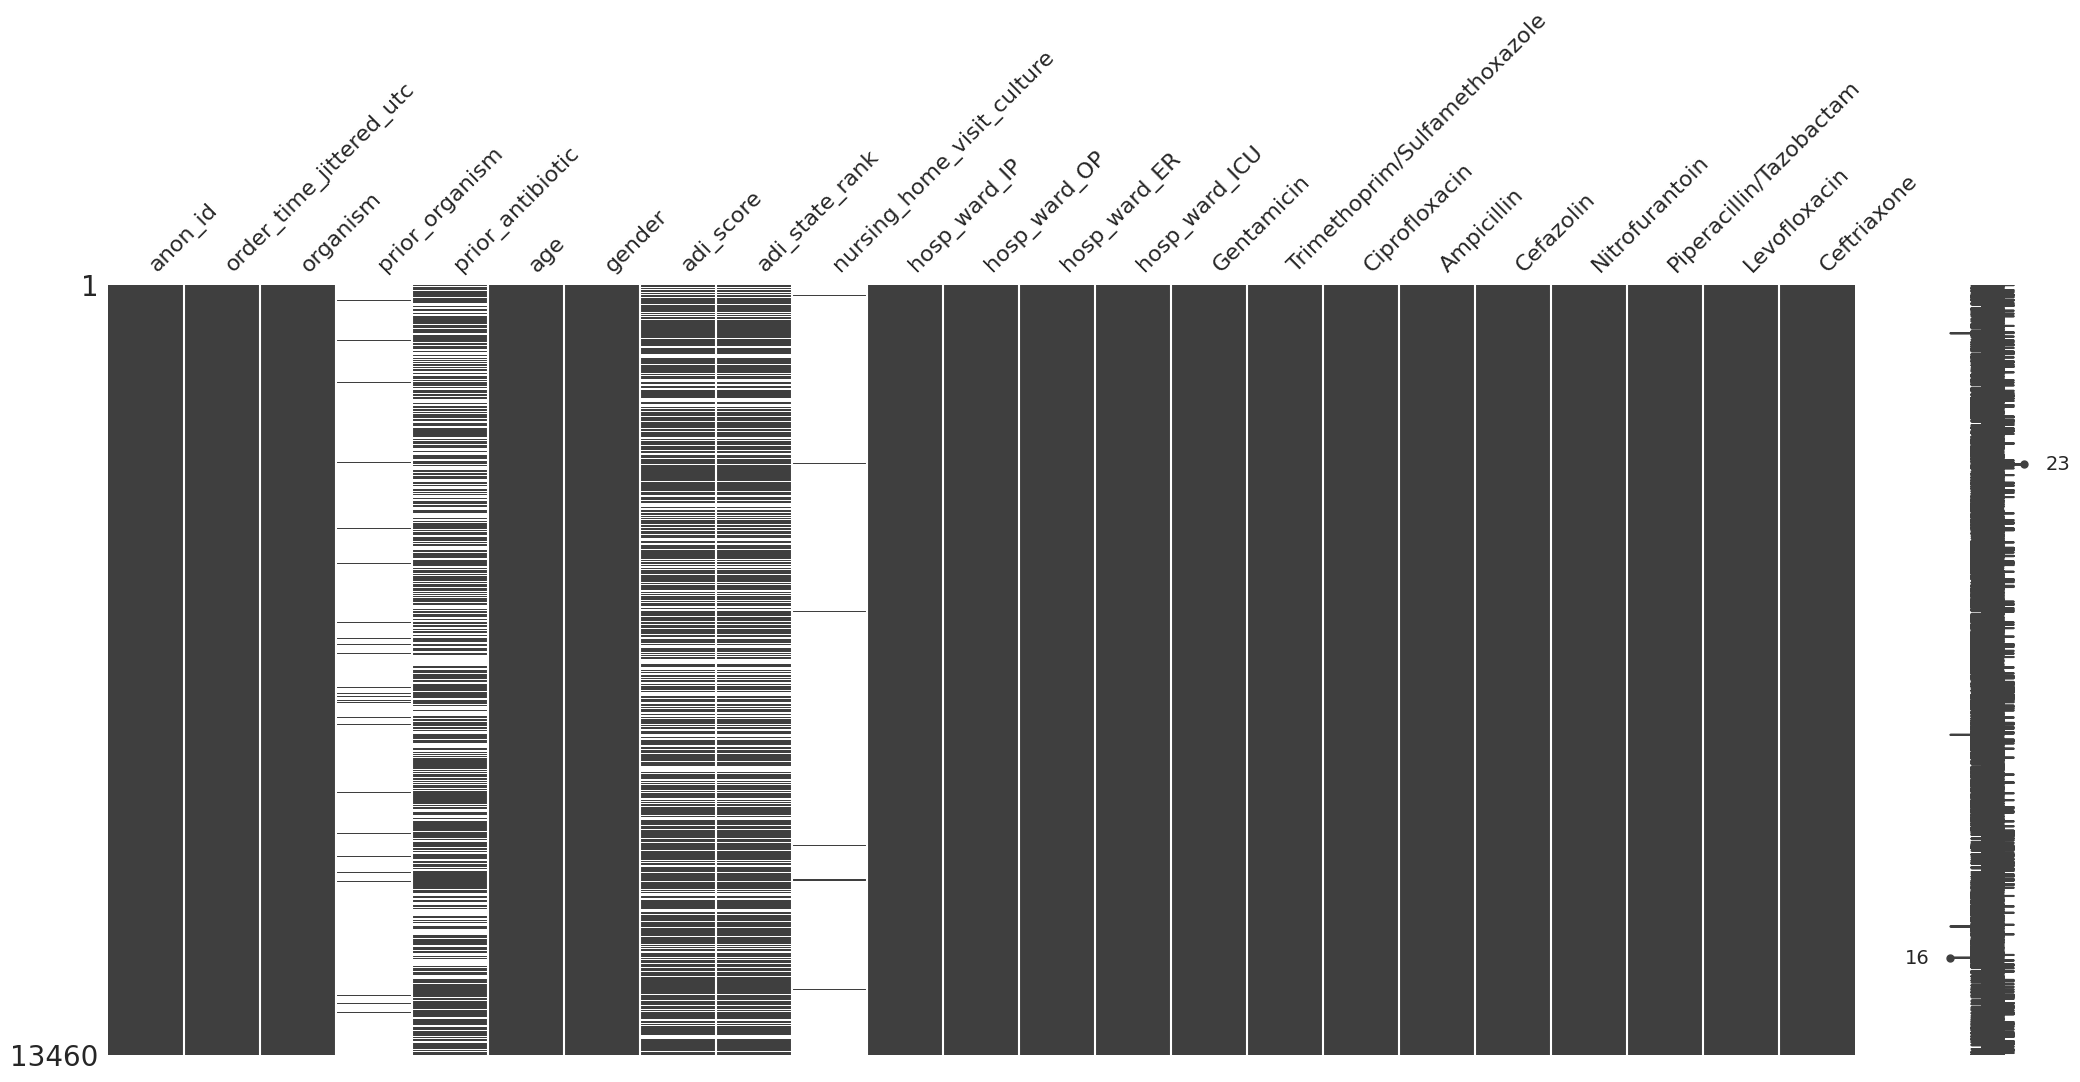

In [77]:
import missingno as msno
msno.matrix(merged_6)
plt.show()


# Preprocess the dataset

In [78]:
df = merged_6.copy()
df = df.dropna(subset=['age'])

In [79]:
# changed categorical age value to int
# 10 == 18-24
# 20 == 25-34
# 30 == 35-44
# 40 == 45-54 etc
def correct_age(x):
  if 'above' in x:
    return 90
  else:
    return int(x[0]+'0')

def anon_id_to_int(x):
  return int(x[2:])

df['age'] = df['age'].apply(correct_age)
df['anon_id'] = df['anon_id'].apply(anon_id_to_int)

In [80]:
# convert date into datetime type
# then sort in ascending order
df = df.rename(columns={'order_time_jittered_utc':'Date'})
df['Date'] = pd.to_datetime(df['Date'])

# filling any nan values with 0
df['prior_organism'] = df['prior_organism'].fillna(0)
df['prior_antibiotic'] = df['prior_antibiotic'].fillna(0)
df['nursing_home_visit_culture'] = df['nursing_home_visit_culture'].fillna(0)
df['adi_score'] = df['adi_score'].fillna(0)
df['adi_state_rank'] = df['adi_state_rank'].fillna(0)

# replacing objects with int values
df['adi_score'] = df['adi_score'].astype(int)
df['adi_state_rank'] = df['adi_state_rank'].astype(int)
df['gender'] = df['gender'].astype(int)
df['Year'] = df['Date'].dt.year

df = df.sort_values(by='Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13455 entries, 2898 to 38298
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   anon_id                        13455 non-null  int64              
 1   Date                           13455 non-null  datetime64[ns, UTC]
 2   organism                       13455 non-null  object             
 3   prior_organism                 13455 non-null  int64              
 4   prior_antibiotic               13455 non-null  int64              
 5   age                            13455 non-null  int64              
 6   gender                         13455 non-null  int64              
 7   adi_score                      13455 non-null  int64              
 8   adi_state_rank                 13455 non-null  int64              
 9   nursing_home_visit_culture     13455 non-null  float64            
 10  hosp_ward_IP            

/tmp/ipython-input-760136894.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['prior_organism'] = df['prior_organism'].fillna(0)
/tmp/ipython-input-760136894.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['prior_antibiotic'] = df['prior_antibiotic'].fillna(0)


In [81]:
df_ecoli = df.loc[(df.organism == "ESCHERICHIA COLI")& (df.Year > 2016)]
df_ecoli = df_ecoli.drop('organism', axis=1)
df_ecoli.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8094 entries, 41830 to 38298
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   anon_id                        8094 non-null   int64              
 1   Date                           8094 non-null   datetime64[ns, UTC]
 2   prior_organism                 8094 non-null   int64              
 3   prior_antibiotic               8094 non-null   int64              
 4   age                            8094 non-null   int64              
 5   gender                         8094 non-null   int64              
 6   adi_score                      8094 non-null   int64              
 7   adi_state_rank                 8094 non-null   int64              
 8   nursing_home_visit_culture     8094 non-null   float64            
 9   hosp_ward_IP                   8094 non-null   int64              
 10  hosp_ward_OP            

In [82]:
df_ecoli.loc[df_ecoli.anon_id == 797704]

,anon_id,Date,prior_organism,prior_antibiotic,age,gender,adi_score,adi_state_rank,nursing_home_visit_culture,hosp_ward_IP,...,Gentamicin,Trimethoprim/Sulfamethoxazole,Ciprofloxacin,Ampicillin,Cefazolin,Nitrofurantoin,Piperacillin/Tazobactam,Levofloxacin,Ceftriaxone,Year
41830,797704,2017-01-01 18:12:00+00:00,0,1,40,0,1,1,0.0,0,...,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2017


In [83]:
df_ecoli['Piperacillin/Tazobactam'].value_counts()

,count
Piperacillin/Tazobactam,
1.0,7981
2.0,113


# Save the raw dataframe

In [84]:
import os
output_filename = 'ARMD_ecoli_raw_dataset.csv'
outdir = '/content/drive/MyDrive/DS_Project_2025/ARMD_data/Final_dataframe/'
df_ecoli.to_csv(os.path.join(outdir, output_filename), index=False)
df_ecoli.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8094 entries, 41830 to 38298
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   anon_id                        8094 non-null   int64              
 1   Date                           8094 non-null   datetime64[ns, UTC]
 2   prior_organism                 8094 non-null   int64              
 3   prior_antibiotic               8094 non-null   int64              
 4   age                            8094 non-null   int64              
 5   gender                         8094 non-null   int64              
 6   adi_score                      8094 non-null   int64              
 7   adi_state_rank                 8094 non-null   int64              
 8   nursing_home_visit_culture     8094 non-null   float64            
 9   hosp_ward_IP                   8094 non-null   int64              
 10  hosp_ward_OP            

# Split the raw dataframe into individual antibiotic test and train datasets

In [85]:
df_ecoli.columns = df_ecoli.columns.str.replace('/', '_')
print(df_ecoli.columns.tolist())

['anon_id', 'Date', 'prior_organism', 'prior_antibiotic', 'age', 'gender', 'adi_score', 'adi_state_rank', 'nursing_home_visit_culture', 'hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU', 'Gentamicin', 'Trimethoprim_Sulfamethoxazole', 'Ciprofloxacin', 'Ampicillin', 'Cefazolin', 'Nitrofurantoin', 'Piperacillin_Tazobactam', 'Levofloxacin', 'Ceftriaxone', 'Year']


In [86]:
# for loop to save the files into test and training datasets
import os
from re import X
from sklearn.model_selection import train_test_split

antibiotics = ['Gentamicin', 'Trimethoprim_Sulfamethoxazole', 'Ciprofloxacin',
                'Ampicillin', 'Cefazolin','Nitrofurantoin','Piperacillin_Tazobactam',
                'Levofloxacin', 'Ceftriaxone']
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for i in antibiotics:
  # split the e_coli dataframe into features and target
  X = df_ecoli.drop(antibiotics, axis=1)
  y = df_ecoli[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=312, stratify=y)

  print("y_train value counts:")
  print(y_train.value_counts(normalize=True))
  print("y_test value counts:")
  print(y_test.value_counts(normalize=True))

  # concat the X and y targets
  train_df = pd.concat([X_train, y_train], axis=1)
  test_df = pd.concat([X_test, y_test], axis=1)

  # make sure that the split in the target is even
  outdir = '/content/drive/MyDrive/DS_Project_2025/ARMD_data/Final_dataframe/'
  train_df.to_csv(os.path.join(outdir, f"{i}_train_data.csv"), index=False)
  test_df.to_csv(os.path.join(outdir, f"{i}_test_data.csv"), index=False)

  print("Train and test sets saved successfully!")

y_train value counts:
Gentamicin
1.0    0.923861
2.0    0.076139
Name: proportion, dtype: float64
y_test value counts:
Gentamicin
1.0    0.924027
2.0    0.075973
Name: proportion, dtype: float64
Train and test sets saved successfully!
y_train value counts:
Trimethoprim_Sulfamethoxazole
1.0    0.771429
2.0    0.228571
Name: proportion, dtype: float64
y_test value counts:
Trimethoprim_Sulfamethoxazole
1.0    0.771464
2.0    0.228536
Name: proportion, dtype: float64
Train and test sets saved successfully!
y_train value counts:
Ciprofloxacin
1.0    0.842162
2.0    0.157838
Name: proportion, dtype: float64
y_test value counts:
Ciprofloxacin
1.0    0.841878
2.0    0.158122
Name: proportion, dtype: float64
Train and test sets saved successfully!
y_train value counts:
Ampicillin
1.0    0.600463
2.0    0.399537
Name: proportion, dtype: float64
y_test value counts:
Ampicillin
1.0    0.600371
2.0    0.399629
Name: proportion, dtype: float64
Train and test sets saved successfully!
y_train value co

# EDA

In [87]:
df_ecoli_ampicillin = df_ecoli[['anon_id','Date',	'prior_organism',
                     'prior_antibiotic',	'age',	'adi_score',	'nursing_home_visit_culture',
                     'hosp_ward_IP',	'hosp_ward_OP','hosp_ward_ER','hosp_ward_ICU', 'Ampicillin']]
print("Number of E. Coli observations:",df_ecoli_ampicillin.shape)
print("unique patients", df_ecoli_ampicillin.anon_id.nunique())
df_ecoli_ampicillin.sample(10)

Number of E. Coli observations: (8094, 12)
unique patients 8084


,anon_id,Date,prior_organism,prior_antibiotic,age,adi_score,nursing_home_visit_culture,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU,Ampicillin
19308,2050056,2022-12-31 22:06:00+00:00,0,1,60,14,0.0,0,1,0,0,2.0
36691,6331845,2022-10-24 23:26:00+00:00,0,1,50,8,0.0,1,0,1,0,2.0
41030,753402,2021-12-30 21:09:00+00:00,0,1,40,3,0.0,1,0,1,0,1.0
38039,6510717,2023-07-16 00:06:00+00:00,0,0,90,0,0.0,1,0,1,0,2.0
5889,1296461,2017-07-07 04:44:00+00:00,0,0,80,1,0.0,1,0,0,1,1.0
28454,2918005,2020-02-29 21:36:00+00:00,0,1,50,47,0.0,0,1,0,0,2.0
7496,1354829,2017-03-26 17:55:00+00:00,0,1,10,0,0.0,0,0,0,0,1.0
21187,2172927,2017-11-30 07:21:00+00:00,0,1,70,32,0.0,1,0,0,1,1.0
19569,2067614,2020-01-30 05:06:00+00:00,0,1,50,2,0.0,0,1,0,0,1.0
4034,1224899,2018-06-24 04:43:00+00:00,0,0,40,1,0.0,0,1,0,0,1.0


In [88]:
from sklearn.model_selection import train_test_split

In [89]:
df_train, df_test = train_test_split(df_ecoli_ampicillin,
                                     shuffle=True,
                                     test_size=0.2,
                                     random_state=312)

In [90]:
df_tt, df_val = train_test_split(df_train,
                                     shuffle=True,
                                     test_size=0.2,
                                     random_state=312)

In [91]:
df_ecoli_ampicillin['Ampicillin'].value_counts()

,count
Ampicillin,
1.0,4860
2.0,3234


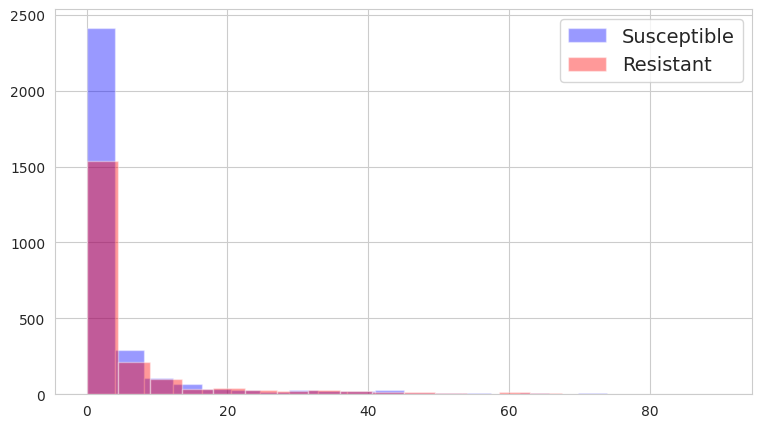

In [93]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(9,5))
plt.hist(df_tt.loc[df_tt['Ampicillin']==1.0].adi_score,
         color = 'blue',
         alpha=0.4,
         label="Susceptible",
         bins=20
         )
plt.hist(df_tt.loc[df_tt['Ampicillin']==2.0].adi_score,
         color = 'red',
         alpha=0.4,
         label="Resistant",
         bins=20
         )

plt.legend(fontsize=14)
plt.show()


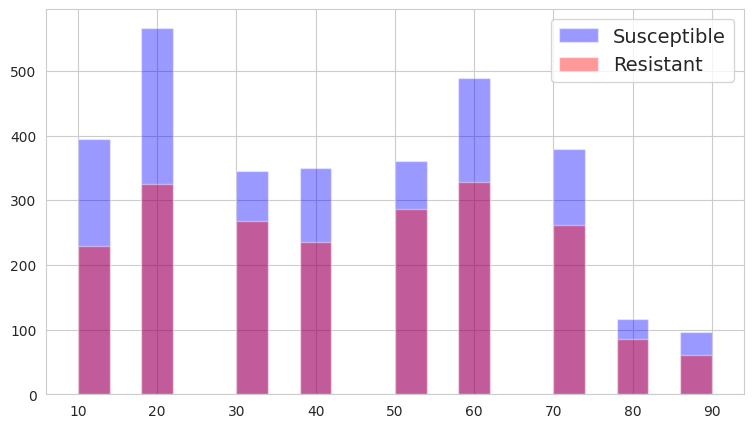

In [94]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(9,5))
plt.hist(df_tt.loc[df_tt['Ampicillin']==1.0].age,
         color = 'blue',
         alpha=0.4,
         label="Susceptible",
         bins=20
         )
plt.hist(df_tt.loc[df_tt['Ampicillin']==2.0].age,
         color = 'red',
         alpha=0.4,
         label="Resistant",
         bins=20
         )

plt.legend(fontsize=14)
plt.show()

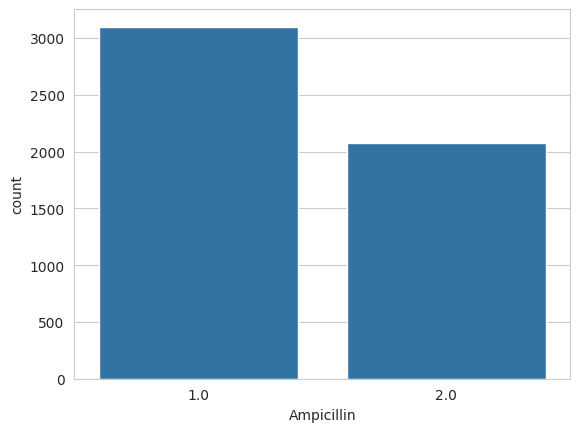

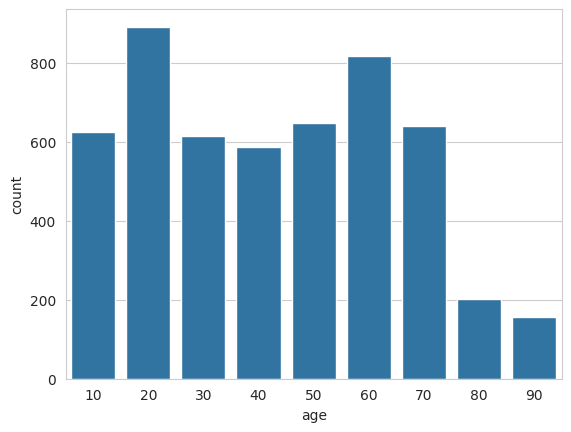

In [95]:
sns.countplot(x='Ampicillin', data=df_tt)
plt.show()

sns.countplot(x='age', data=df_tt)
plt.show()

<Axes: xlabel='Ampicillin', ylabel='age'>

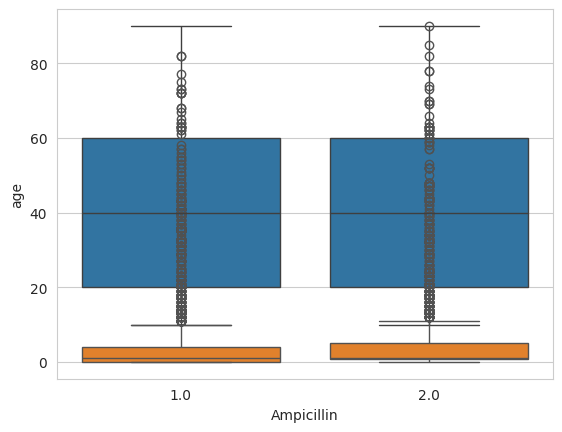

In [96]:
sns.boxplot(x='Ampicillin', y='age', data=df_tt)
sns.boxplot(x='Ampicillin', y='adi_score', data=df_tt)

<Axes: >

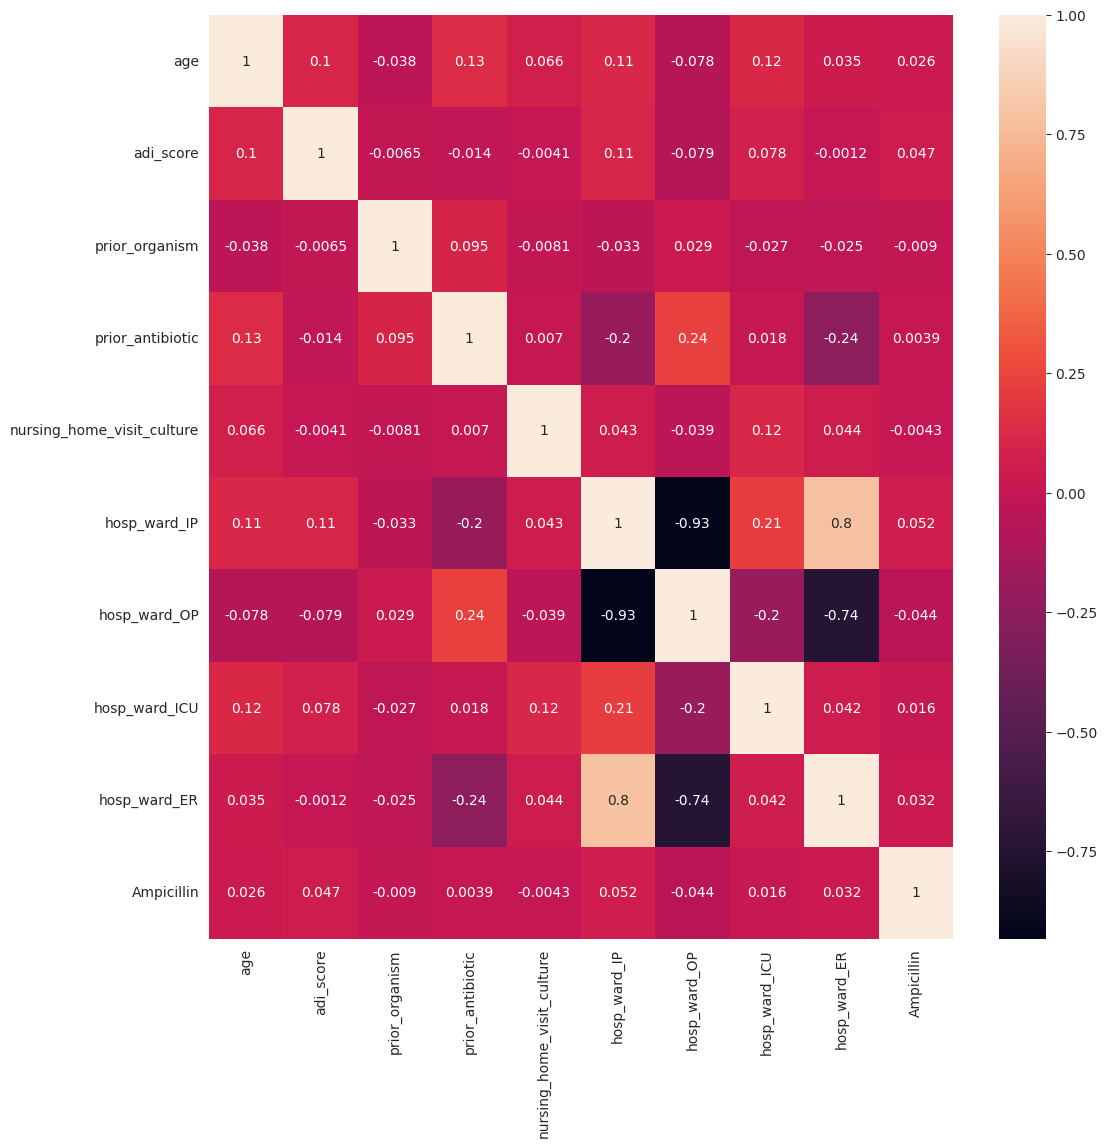

In [97]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_tt[['age','adi_score','prior_organism',	'prior_antibiotic',	'nursing_home_visit_culture','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ICU','hosp_ward_ER','Ampicillin']].corr(), annot=True)


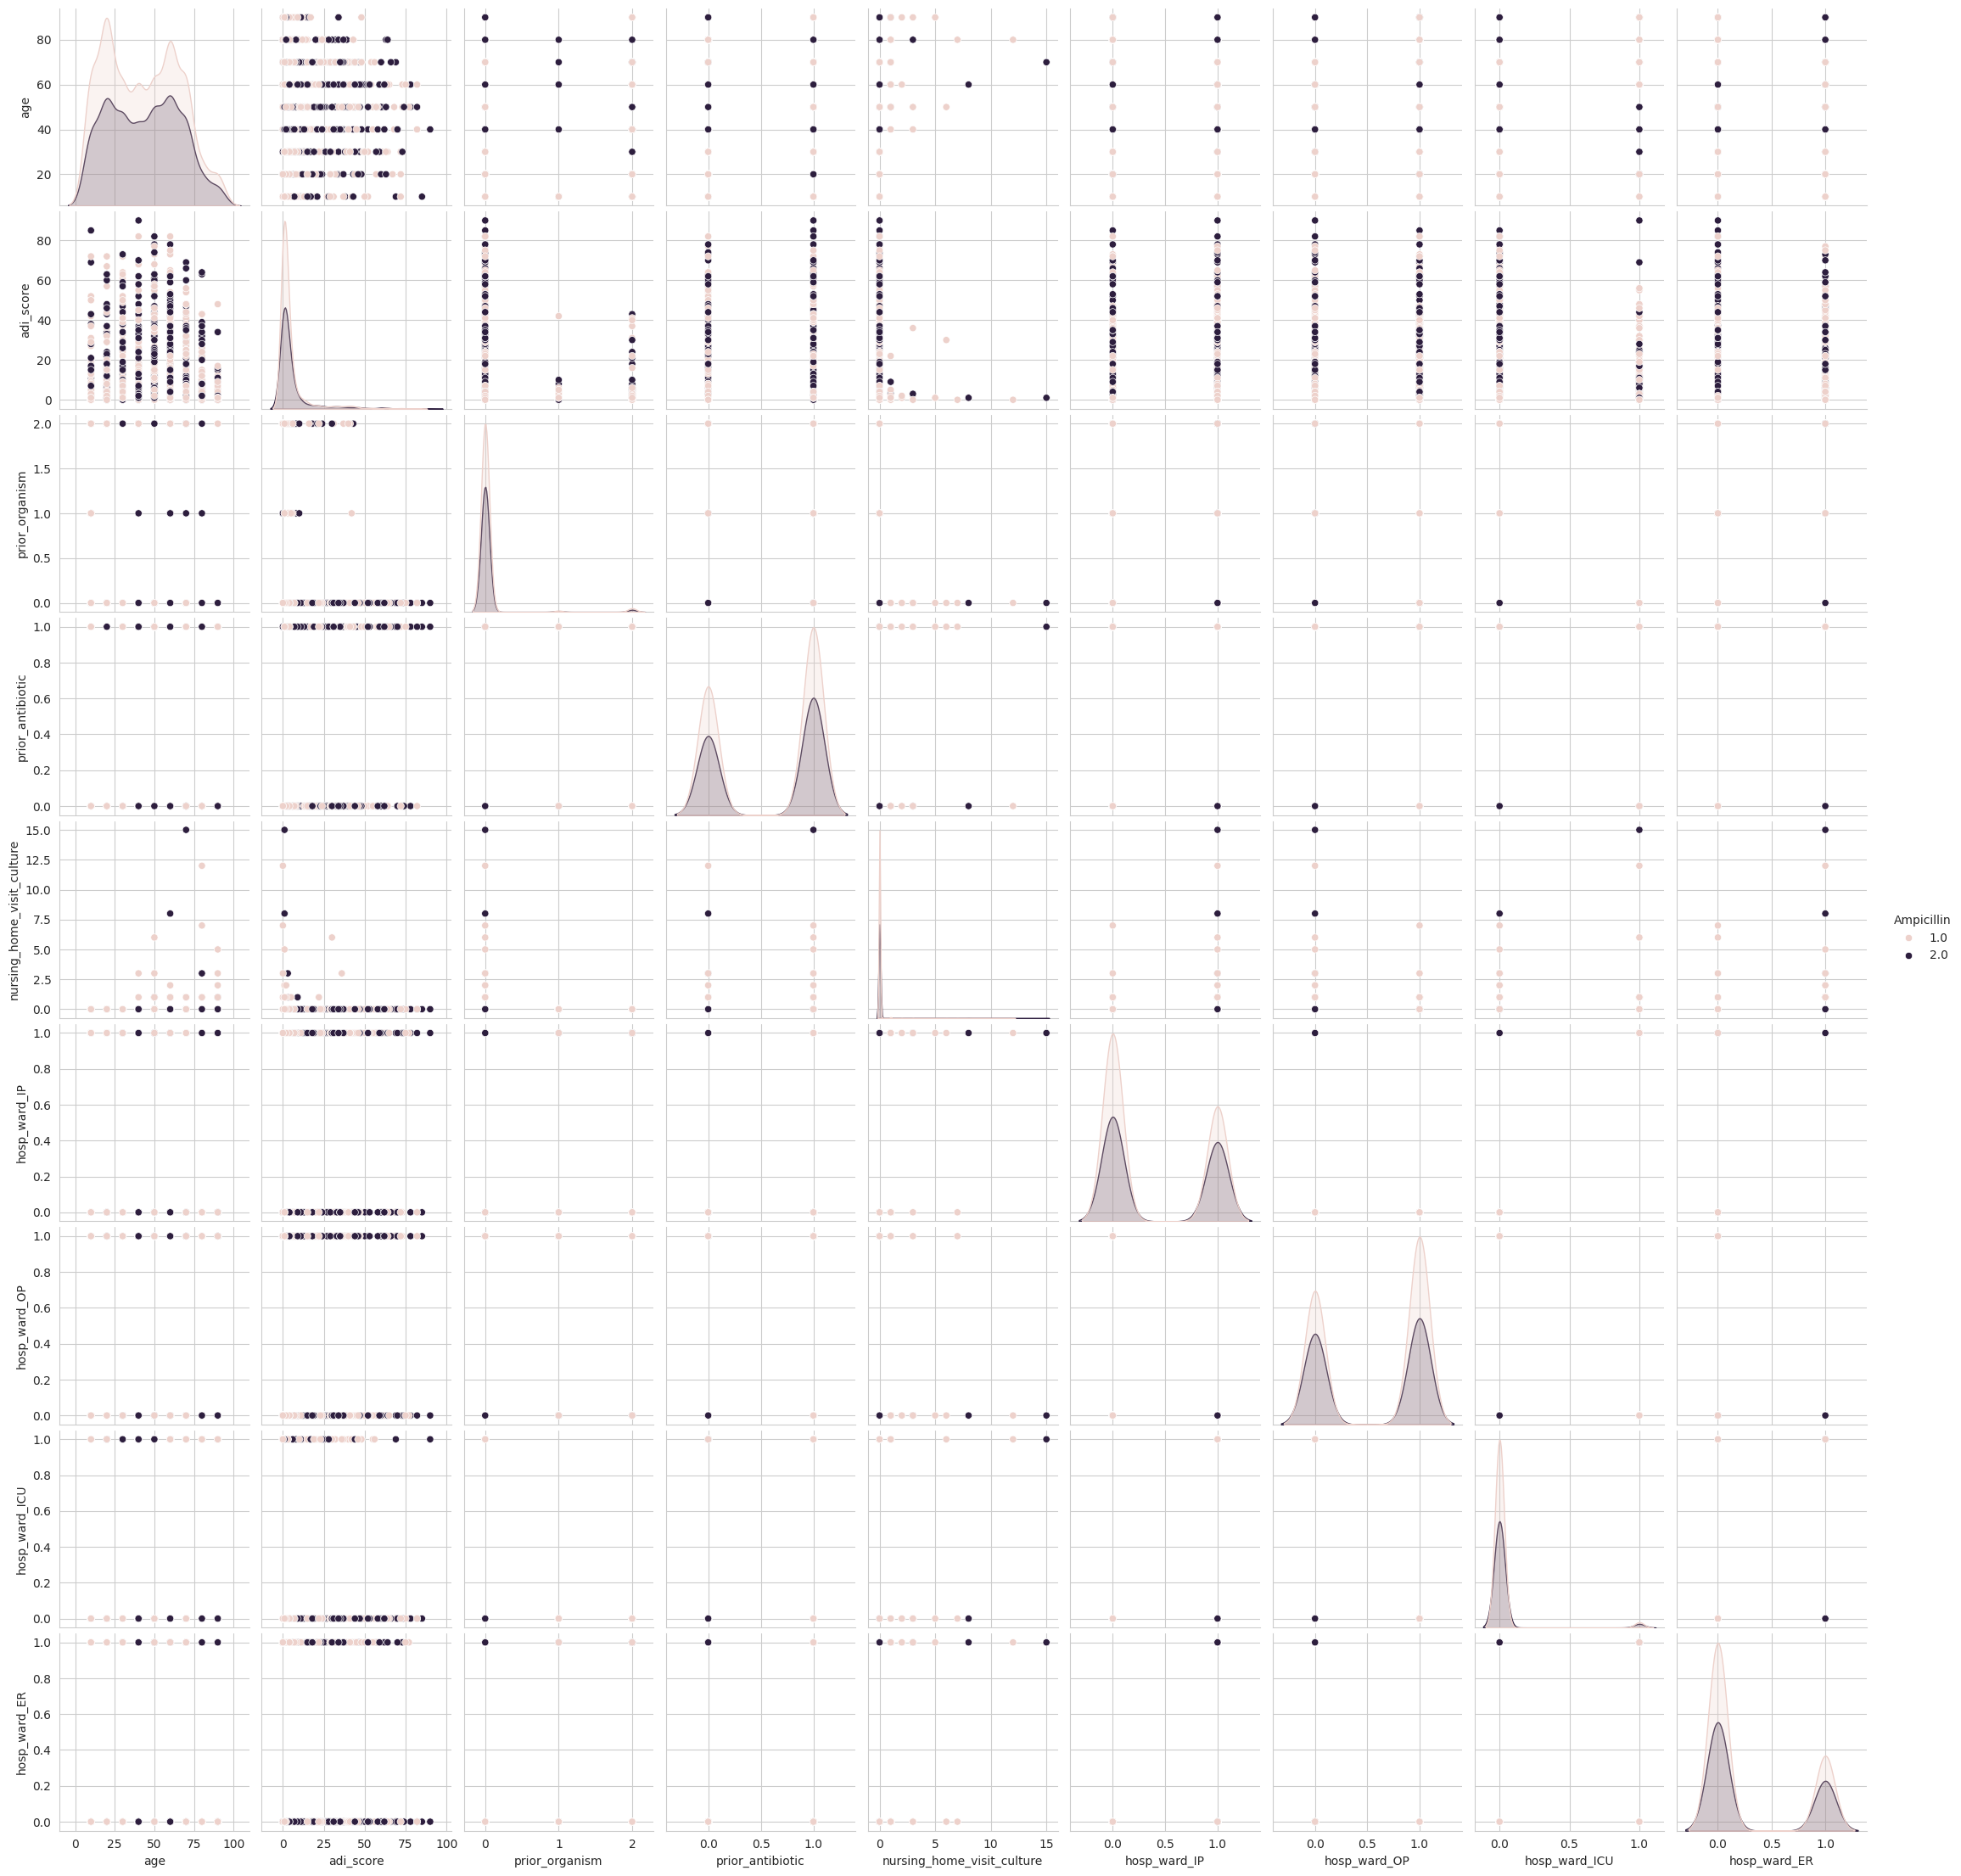

In [98]:
sns.pairplot(df_tt, hue='Ampicillin', vars=['age','adi_score','prior_organism',	'prior_antibiotic',	'nursing_home_visit_culture','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ICU','hosp_ward_ER'])